# NGC 1866: Age Determination

In [3]:
import numpy as np
import subprocess

from astropy.io import fits
from astropy.table import Table, Column, join
import astropy.units as u
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.timeseries import BoxLeastSquares, LombScargle
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from scipy.stats import chisquare
from scipy.signal import medfilt, find_peaks
from scipy.spatial.distance import cdist

from ccdproc import CCDData, Combiner, subtract_overscan, trim_image, create_deviation

from photutils import DAOStarFinder, CircularAperture, aperture_photometry

from glob import glob
from itertools import product

import matplotlib

#%matplotlib inline
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Loading data

- `phot_table`: The observation data
- `isochrone_table`: The isochrone models

For this analysis we will use the filters F438W (B) and F555W (V) to make B vs. B-V HR diagram.

In [2]:
phot_table = Table.read("../data/NGC1866_data_tables/ngc1866_cluster_stars1_corrected_final.short.dat",format='ascii')

In [5]:
isochrone_table = Table.read("../data/NGC1866_data_tables/isoc_z008_full_wfc3.dat",format='ascii')

### Plotting all the isochrones all at once
(Just for fun)

<IPython.core.display.Javascript object>


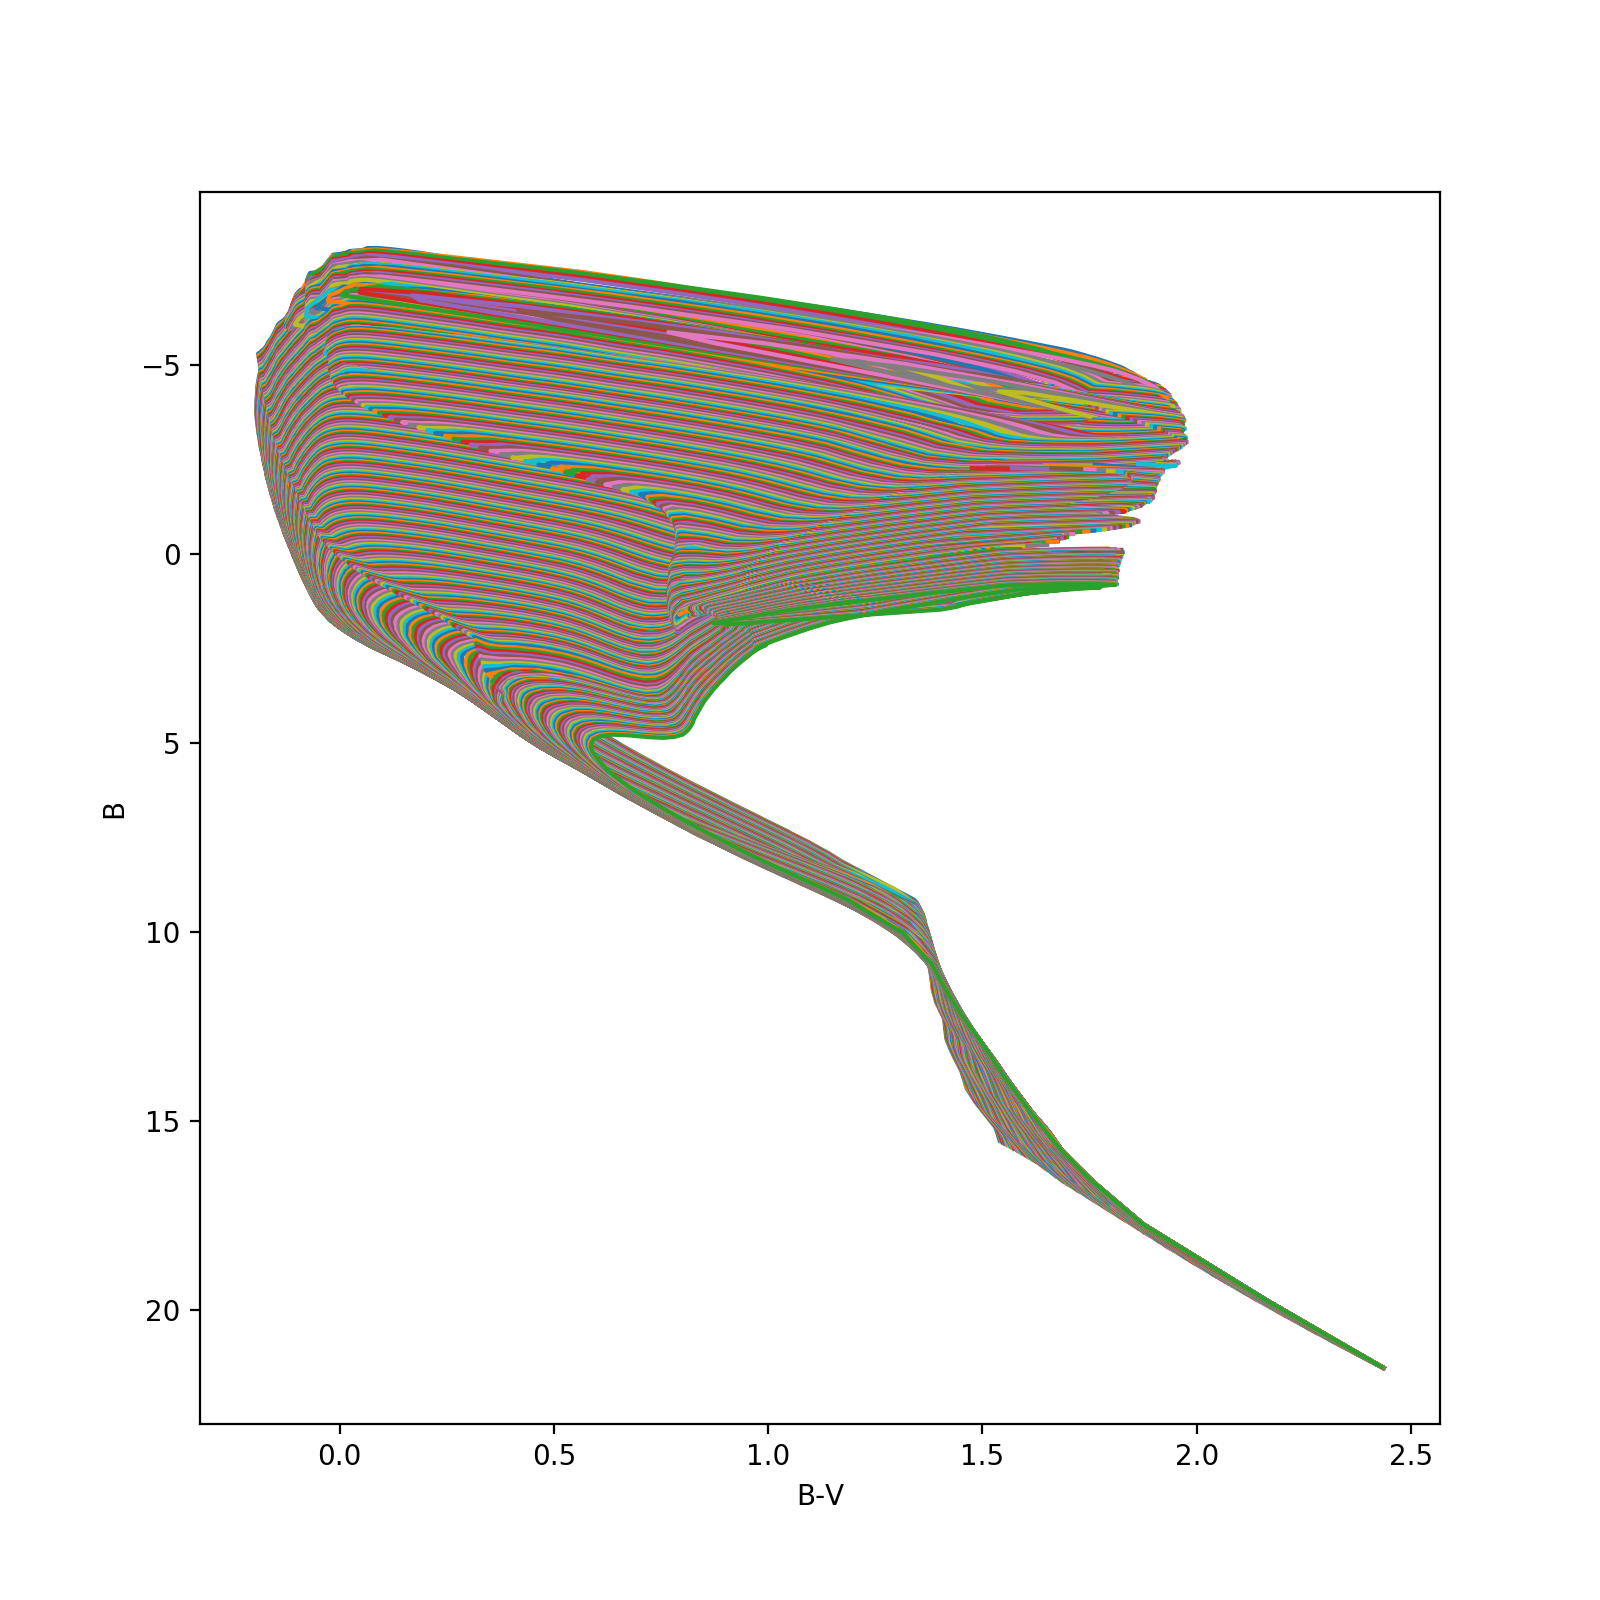

In [221]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

for age in np.unique(isochrone_table['log(age/yr)']):
    single_age = isochrone_table[isochrone_table['log(age/yr)']==age]
    ax.plot(single_age["F438W"]-single_age['F555W'],single_age["F438W"], '-')

ax.set_ylabel("B")
ax.set_xlabel("B-V")

ax.set_ylim(ax.get_ylim()[::-1])
        
plt.show()

In this file you will find the isochrones for a very wide range of ages.  At each age (given as the logarithm in column 2) you will find a range of masses and the magnitudes in the filters at this mass.

So you will need to select an age (part of the project is for you to discover how to do this) and plot the isochrone at that age.  i.e. plot a single age model over the data.

You will need to take into account the distance to the source and also the extinction.  Here are the extinction coefficients for the filters of interest.

    A_F555W = A_V
    A_F438W = 1.33*A_V

You should correct the *models* for distance and extinction (not the observations).  For this, you need to *add* the distance modulus to the model magnitudes.

For the extinction, you need to *add* the extinction values to the model magnitudes.   For example, if A_V = 1.0, then A_F438W = 1.33.  You then would add these values to the models:

    m_f438w = M_f438W + distance modulus + 1.33
    m_f555w = M_f555W + distance modulus + 1.0

As initial guesses you can use distance modulus = 18.5 and A_V=0.3 (you will need to iterate on these values)

The first thing to do is to determine an initial guess for the age of the cluster.  Please focus on the main sequence turn-off (MSTO) and possibly the post-main sequence features.  Once you have an estimate for the age, please let me know what it is, how you estimated it, and (if you can) any plots that you can show.

## Fitting functions

The extinction coefficients for the filters of interest are:

    A_F555W = A_V
    A_F438W = 1.33*A_V
    
Given an extinction value (A_V) and distance modulus (DM) we calculate the apparent magnitudes for the models as:
    
    m_f438w = M_f438W + DM + A_V*1.33
    m_f555w = M_f555W + DM + A_V

I then determine the best fit age by calculating the mean square error for each isochrone model by finding the minimum distance between each observed point and the isochrone model, and then taking the mean square of those distances.  I minimize this value to determine the best log(age/year). 

In [83]:
def get_fit_err(model, observations):
    """
    Calculate the Mean Square Error for given model and observations.
    
    Parameters
    ----------
    model : array
        Model array, should be n x 2 dimensions, i.e. [[B_0,BV_0],[B_1,BV_1],[B_2,BV_2],...]
    observations : array
        Observations array, should be n x 2 dimensions, i.e. [[B_0,BV_0],[B_1,BV_1],[B_2,BV_2],...]
        
    Returns
    -------
    response : float
        The mean square error of the observations array assuming the model array contains the true values.
    """
    
    distance_arrays = cdist(observations, model)
    min_dists = distance_arrays.min(1)

    return (1/len(min_dists)) * sum(min_dists**2)

In [89]:
def fit_isochrone(isochrone_table, phot_table, distance_modulus, A_V):
    """
    Given distance_modulus and A_V values, find the best fit age for the photmetric data given.
    
    Parameters
    ----------
    isochrone_table : astropy.table.Table
        Table contianing isochrone models, must have columns with names: log(age/yr), F438W, F555W
    phot_table : astropy.table.Table
        Table containing the observation data, must have columns with names: f438w, f555w
        
    Returns
    -------
    response : tuple
        (best fit age, best fit age mean square error)
    """
    
    # Setting up the observed array
    observed_B_BV = list(zip(phot_table["f438w"], phot_table["f438w"]-phot_table["f555w"]))
    
    best_age = 0
    best_age_err = 100
    for age in np.unique(isochrone_table['log(age/yr)']):
        single_age = isochrone_table[isochrone_table['log(age/yr)'] == age]
        model_B_BV = list(zip(single_age["F438W"] + distance_modulus + (A_V*1.33), 
                              single_age["F438W"] - single_age['F555W']  + (A_V*0.33)))
        
        mean_sq_err = get_fit_err(model_B_BV, observed_B_BV)
        
        if mean_sq_err < best_age_err:
            best_age_err = mean_sq_err
            best_age = age
            
    return (best_age, best_age_err)
               

## Iterating over distance modulus and A_V

Probably the better thing to do at this point would have been to use my calculated Cephied periods and the Cepheid period-luminosity relation to get an initial guess distance modulus and A_V value, instead I took the suggested values of 18.5 and 0.3 respectively from Dr. Bastian, and used that as the central value for my iterations.

I calculate the best fit and mean square error for a grid of distance modulus and A_V value, and plot the result.

In [160]:
all_ages = []
all_age_errs = []
all_dist_mods = []
all_A_Vs = []

for dist_mod, A_V in product(np.linspace(15,25,21), np.linspace(0,1,21)):

    age, age_err = fit_isochrone(isochrone_table, phot_table, dist_mod, A_V)
    
    all_ages.append(age)
    all_age_errs.append(age_err)
    all_dist_mods.append(dist_mod)
    all_A_Vs.append(A_V)


In [162]:
age_fit_table = Table(names=["log(age/yr)","age fit error","distance modulus","A_V"],
                      data=[all_ages,all_age_errs,all_dist_mods,all_A_Vs])

#### Write/read the reults table

This calculation took a really long time, so this way I can just read it in rather than having to do the whole thing over.

In [164]:
#age_fit_table.write("../data/NGC1866_data_tables/age_fit_table.ecsv",format="ascii.ecsv")
age_fit_table = Table.read("../data/NGC1866_data_tables/age_fit_table.ecsv")

#### Collecting the best fit values

In [217]:
best_ind = np.argmin(age_fit_table["age fit error"])

dist_mod = age_fit_table["distance modulus"][best_ind]
A_V = age_fit_table["A_V"][best_ind]
age = age_fit_table["log(age/yr)"][best_ind]
age_err = age_fit_table["age fit error"][best_ind]

#### Plotting the error grid

<IPython.core.display.Javascript object>


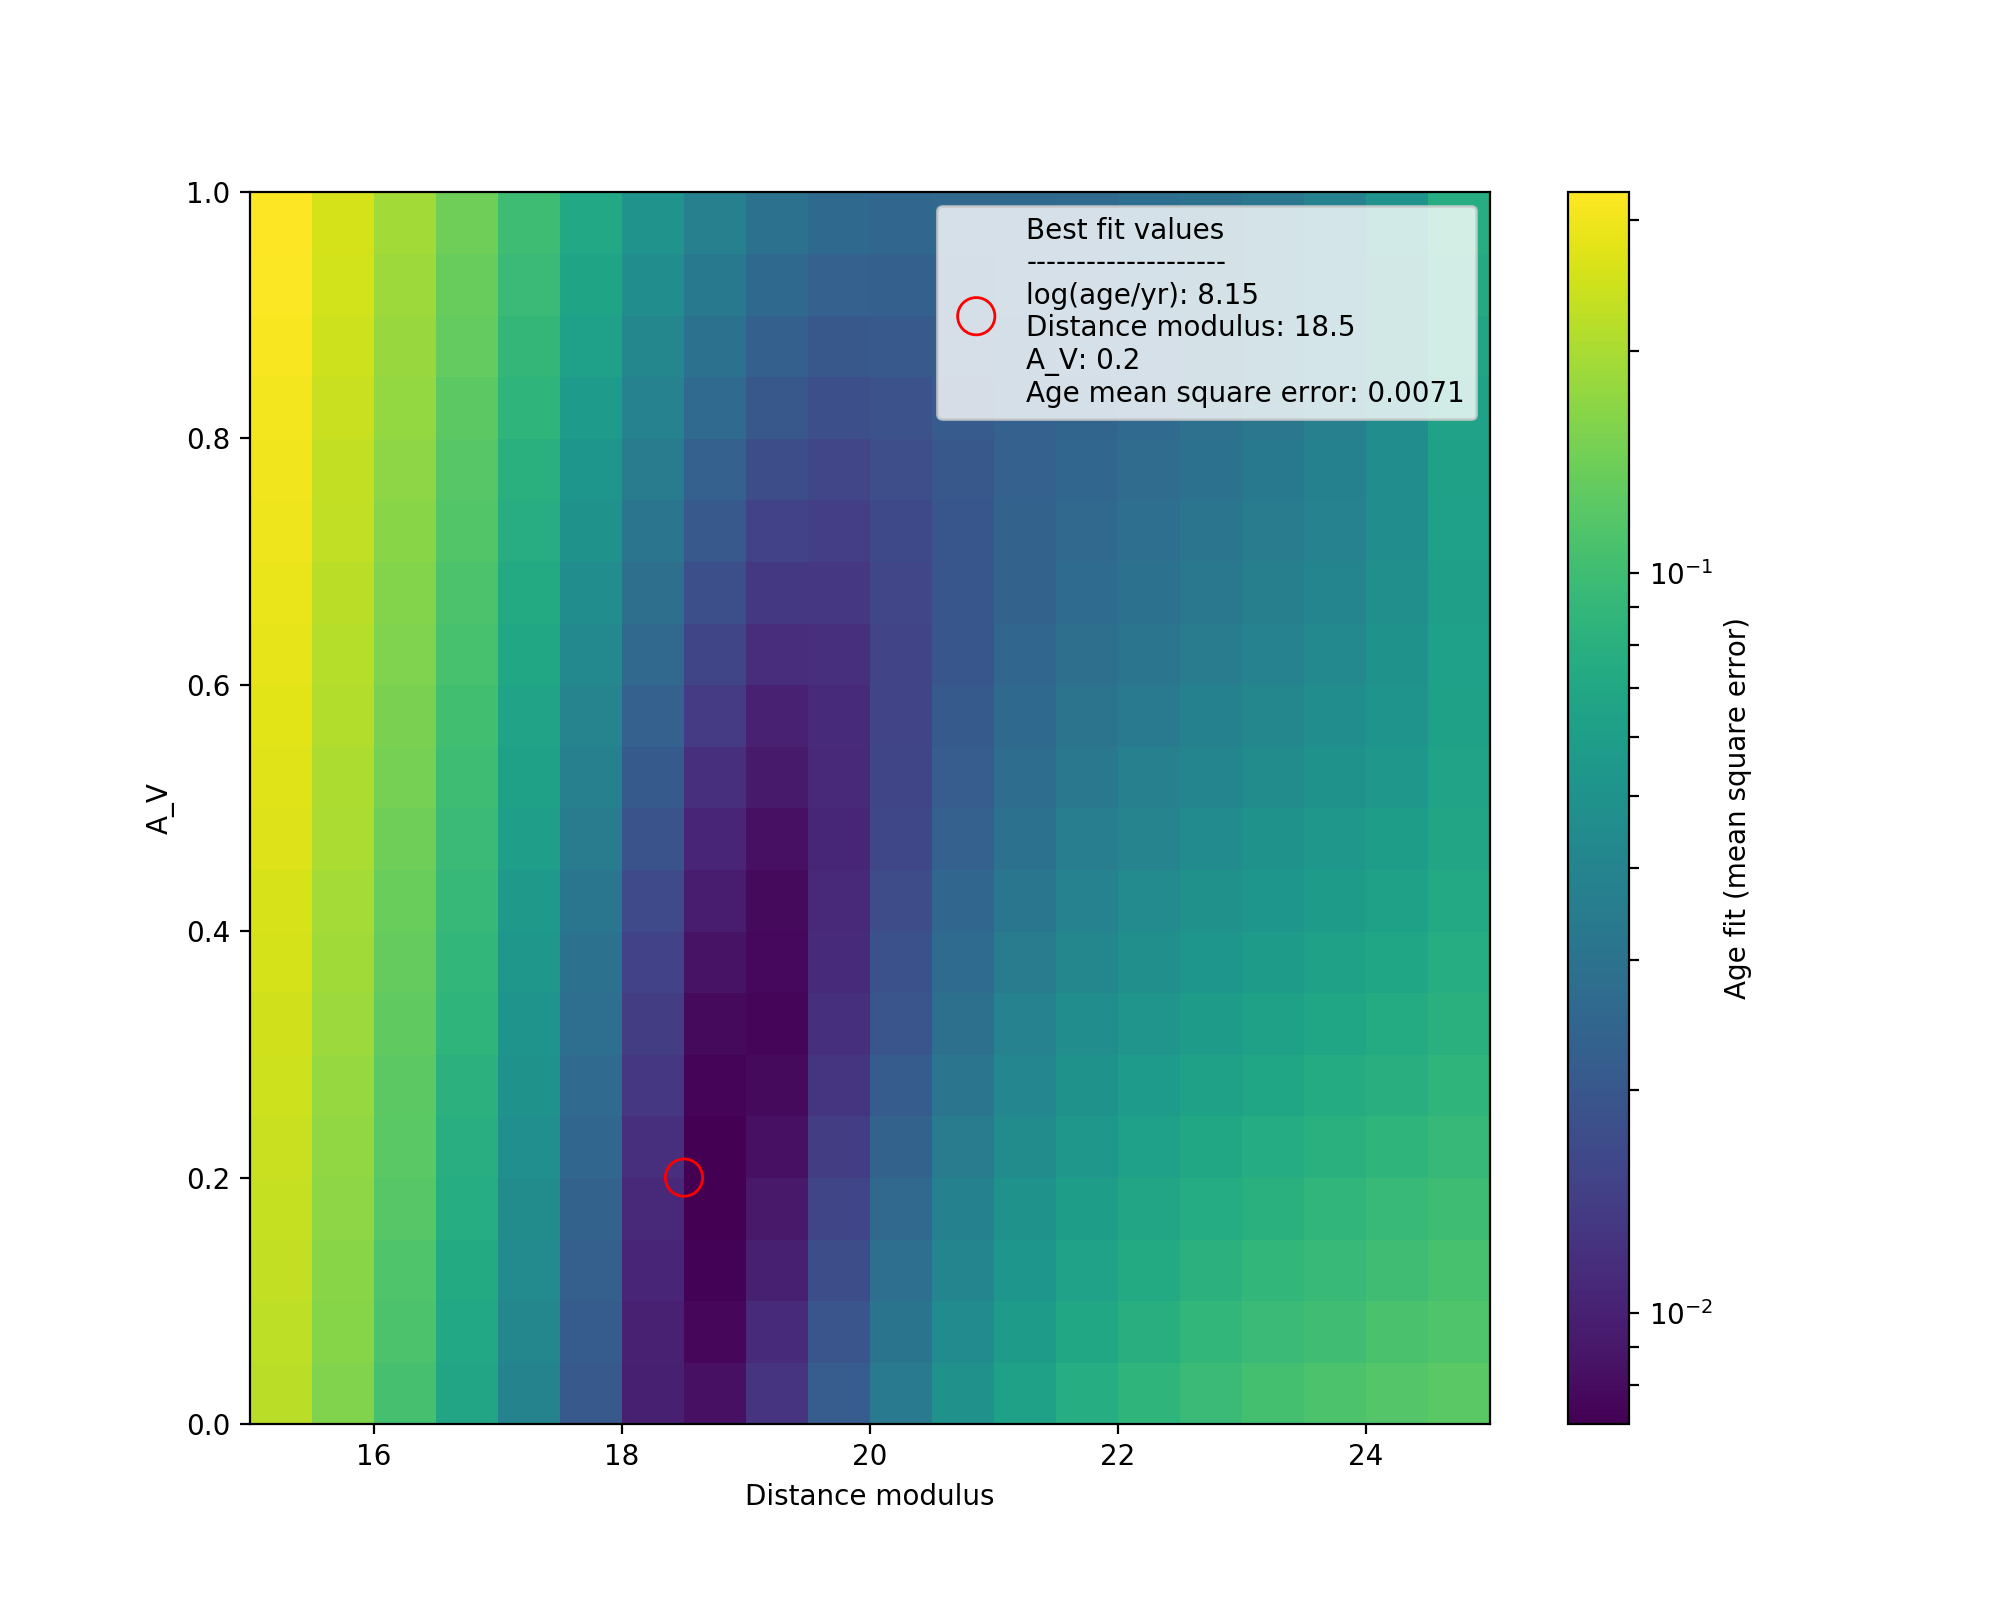

In [218]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
   
im = ax.pcolormesh(age_fit_table["distance modulus"].reshape(21,21),
                   age_fit_table["A_V"].reshape(21,21),
                   age_fit_table["age fit error"].reshape(21,21),
                   cmap='viridis',norm=LogNorm())
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Age fit (mean square error)')

best_fit_ind = np.argmin(all_age_errs)
ax.scatter(dist_mod, A_V, marker='o', edgecolor='red', facecolor="None", s=180,
           label=f"Best fit values\n--------------------\nlog(age/yr): {age:.3}\nDistance modulus: {dist_mod:.4}\nA_V: {A_V:.3}\nAge mean square error: {age_err:.2}")

ax.legend()
ax.set_xlabel("Distance modulus")
ax.set_ylabel("A_V")

plt.savefig("../doc/plots/age_fit.pdf")

plt.show()

#### Plotting the best fit isochron and observational data

<IPython.core.display.Javascript object>


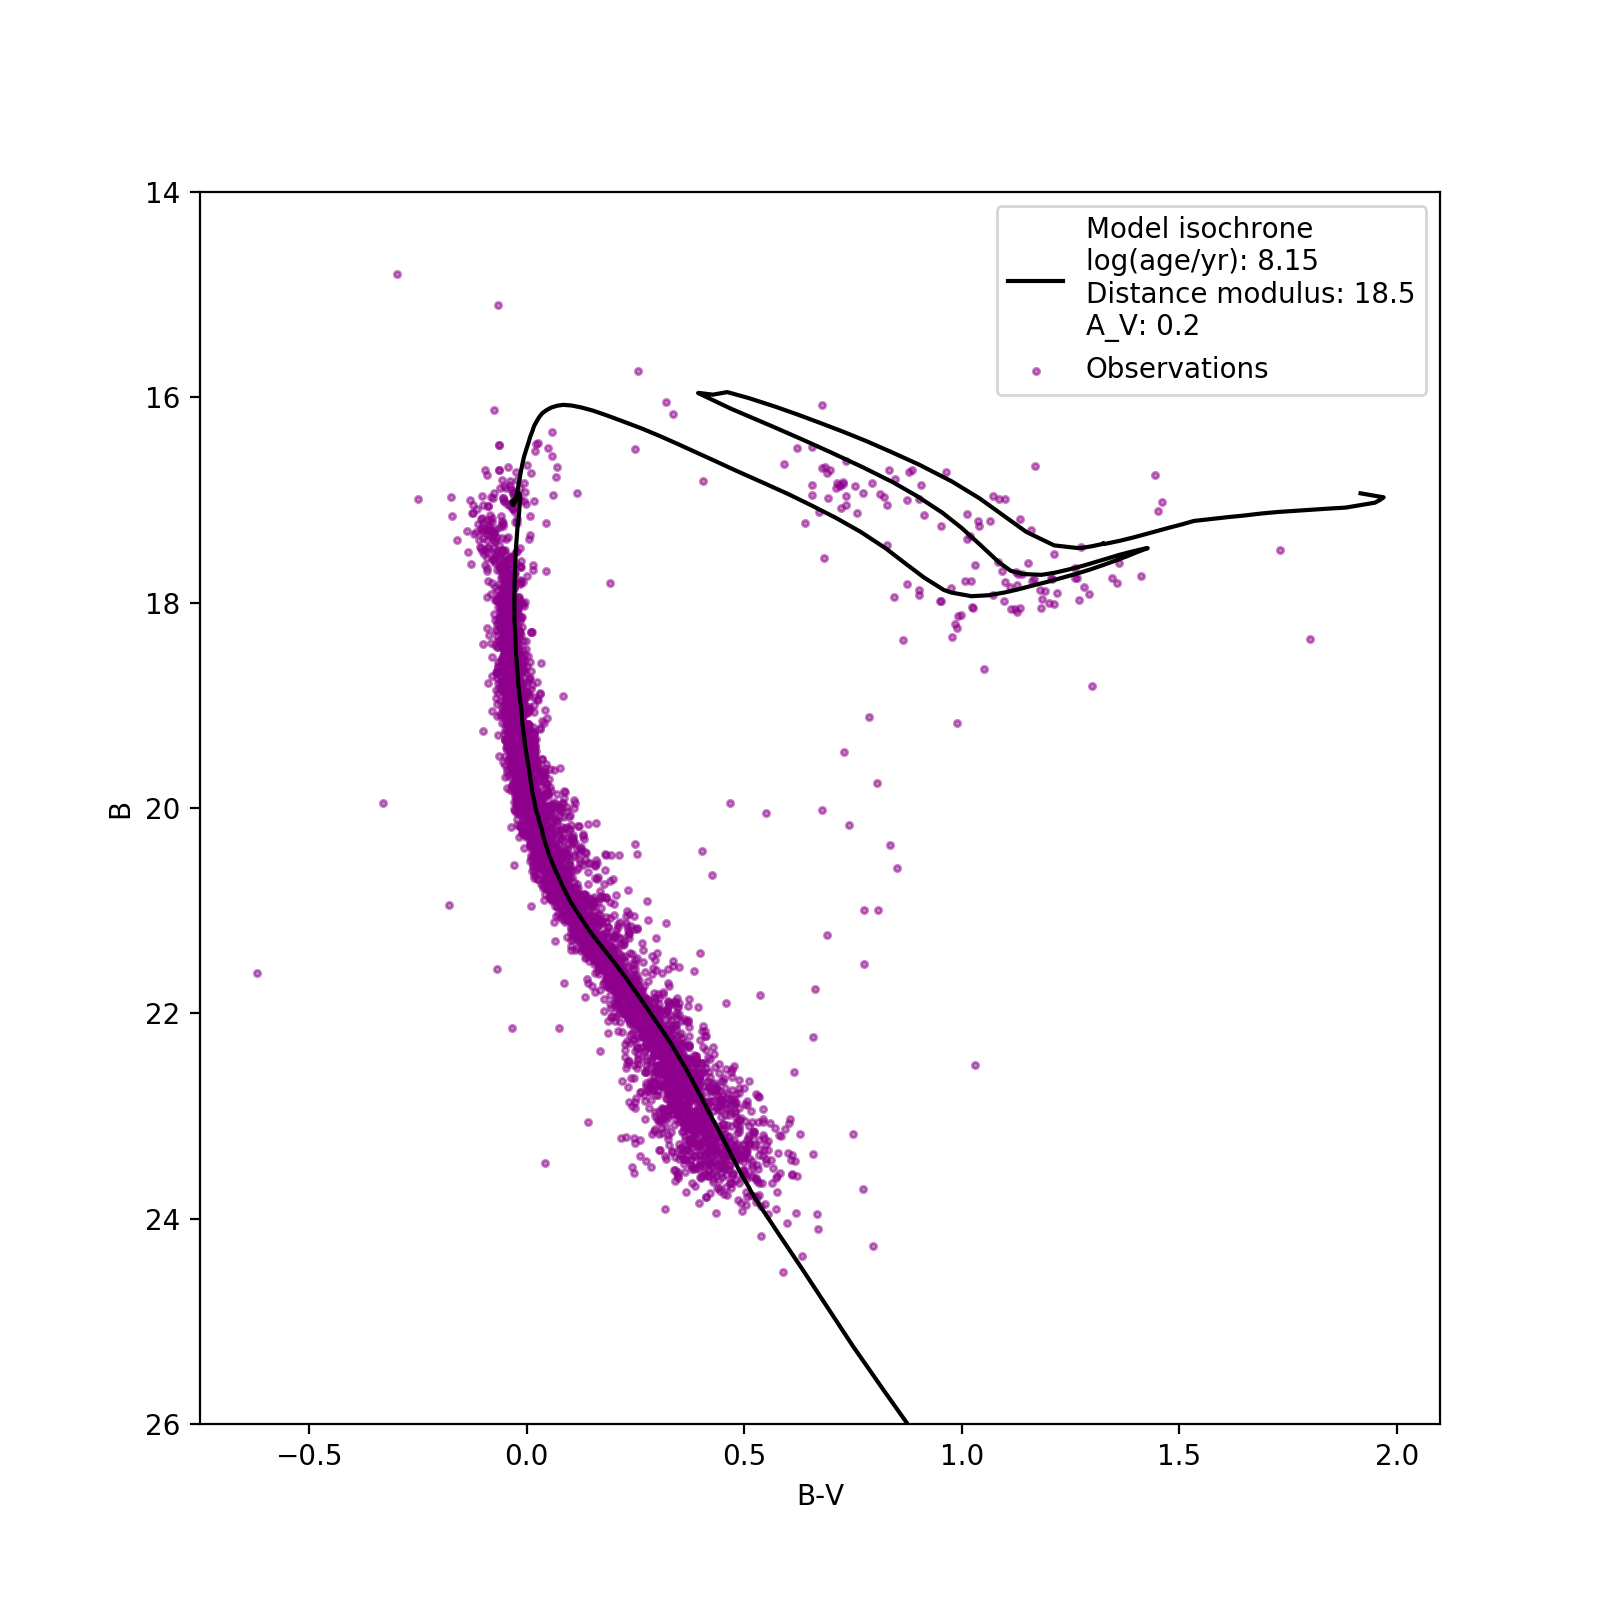

In [219]:
best_isochrone = isochrone_table[isochrone_table['log(age/yr)'] == age]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# observations    
ax.scatter(phot_table["f438w"]-phot_table["f555w"], phot_table["f438w"], 
           marker='o', c='#8e008c', alpha=0.5, s=5, label="Observations")

# isochrone 
ax.plot(best_isochrone["F438W"] - best_isochrone['F555W']  + (A_V*0.33),
        best_isochrone["F438W"] + dist_mod + (A_V*1.33), '-', color='black',
        label=f"Model isochrone\nlog(age/yr): {age:.3}\nDistance modulus: {dist_mod:.4}\nA_V: {A_V:.3}")

ax.set_ylim(26,14)

ax.legend()

ax.set_ylabel("B")
ax.set_xlabel("B-V")

plt.show()

### Trying to get a better fit 

Seeing if I can refine the values by doing a second iteration around the best fit value from the first iteration.

In [220]:
all_ages = []
all_age_errs = []
all_dist_mods = []
all_A_Vs = []

for dist_mod, A_V in product(np.linspace(18.2,18.8,11), np.linspace(.1,0.3,11)):

    age, age_err = fit_isochrone(isochrone_table, phot_table, dist_mod, A_V)
    
    all_ages.append(age)
    all_age_errs.append(age_err)
    all_dist_mods.append(dist_mod)
    all_A_Vs.append(A_V)

In [222]:
age_fit_table_zoom = Table(names=["log(age/yr)","age fit error","distance modulus","A_V"],
                           data=[all_ages,all_age_errs,all_dist_mods,all_A_Vs])

#### Write/read the results table

This one didn't take as long because I was running over fewer values, but it still took awhile.

In [224]:
#age_fit_table_zoom.write("../data/NGC1866_data_tables/age_fit_table_zoom.ecsv",format="ascii.ecsv")
age_fit_table_zoom = Table.read("../data/NGC1866_data_tables/age_fit_table.ecsv")

#### Collecting the best fit values

In [248]:
best_ind = np.argmin(age_fit_table_zoom["age fit error"])

dist_mod = age_fit_table_zoom["distance modulus"][best_ind]
A_V = age_fit_table_zoom["A_V"][best_ind]
age = age_fit_table_zoom["log(age/yr)"][best_ind]
age_err = age_fit_table_zoom["age fit error"][best_ind]

#### Plotting the error grid

<IPython.core.display.Javascript object>


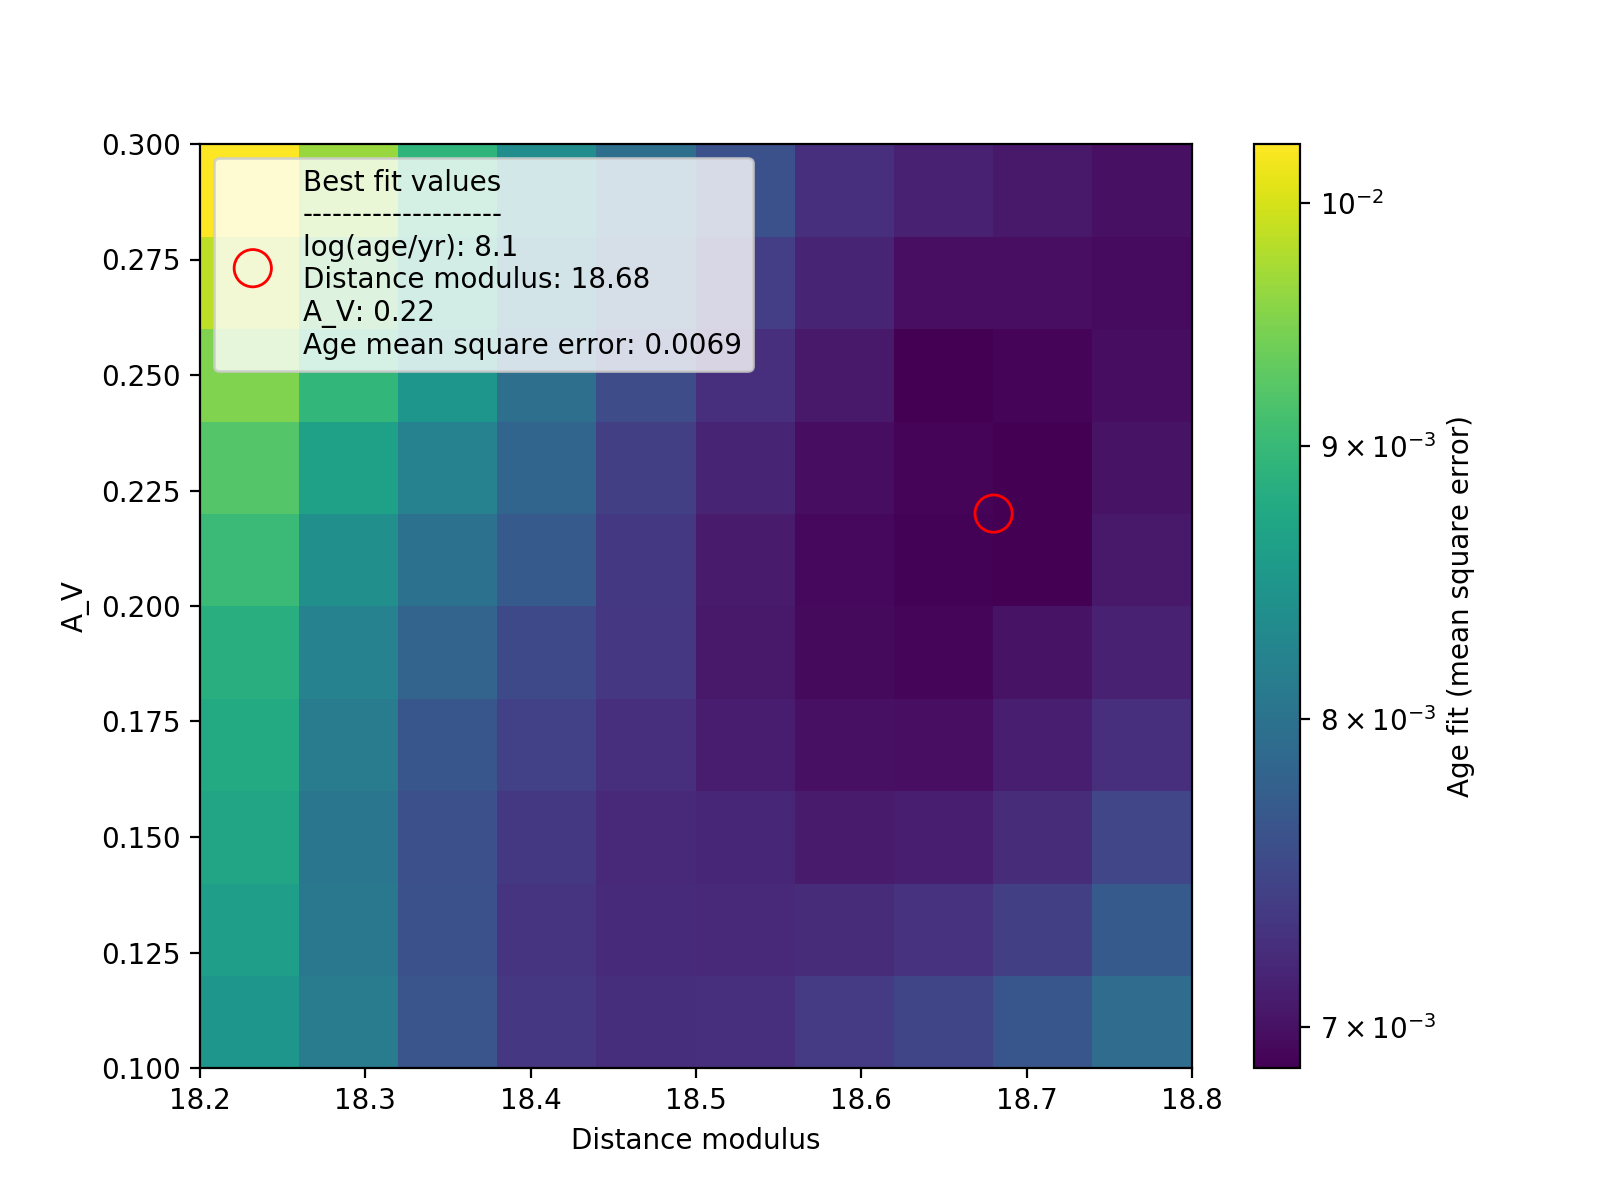

In [229]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
   
im = ax.pcolormesh(age_fit_table_zoom["distance modulus"].reshape(11,11),
                   age_fit_table_zoom["A_V"].reshape(11,11),
                   age_fit_table_zoom["age fit error"].reshape(11,11),
                   cmap='viridis',norm=LogNorm())
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Age fit (mean square error)')

best_fit_ind = np.argmin(all_age_errs)
ax.scatter(dist_mod, A_V, marker='o', edgecolor='red', facecolor="None", s=180,
           label=f"Best fit values\n--------------------\nlog(age/yr): {age:.3}\nDistance modulus: {dist_mod:.4}\nA_V: {A_V:.3}\nAge mean square error: {age_err:.2}")

ax.legend(loc="upper left")
ax.set_xlabel("Distance modulus")
ax.set_ylabel("A_V")

plt.savefig("../doc/plots/age_fit.pdf")

plt.show()

#### Plotting the best fit isochrone

<IPython.core.display.Javascript object>


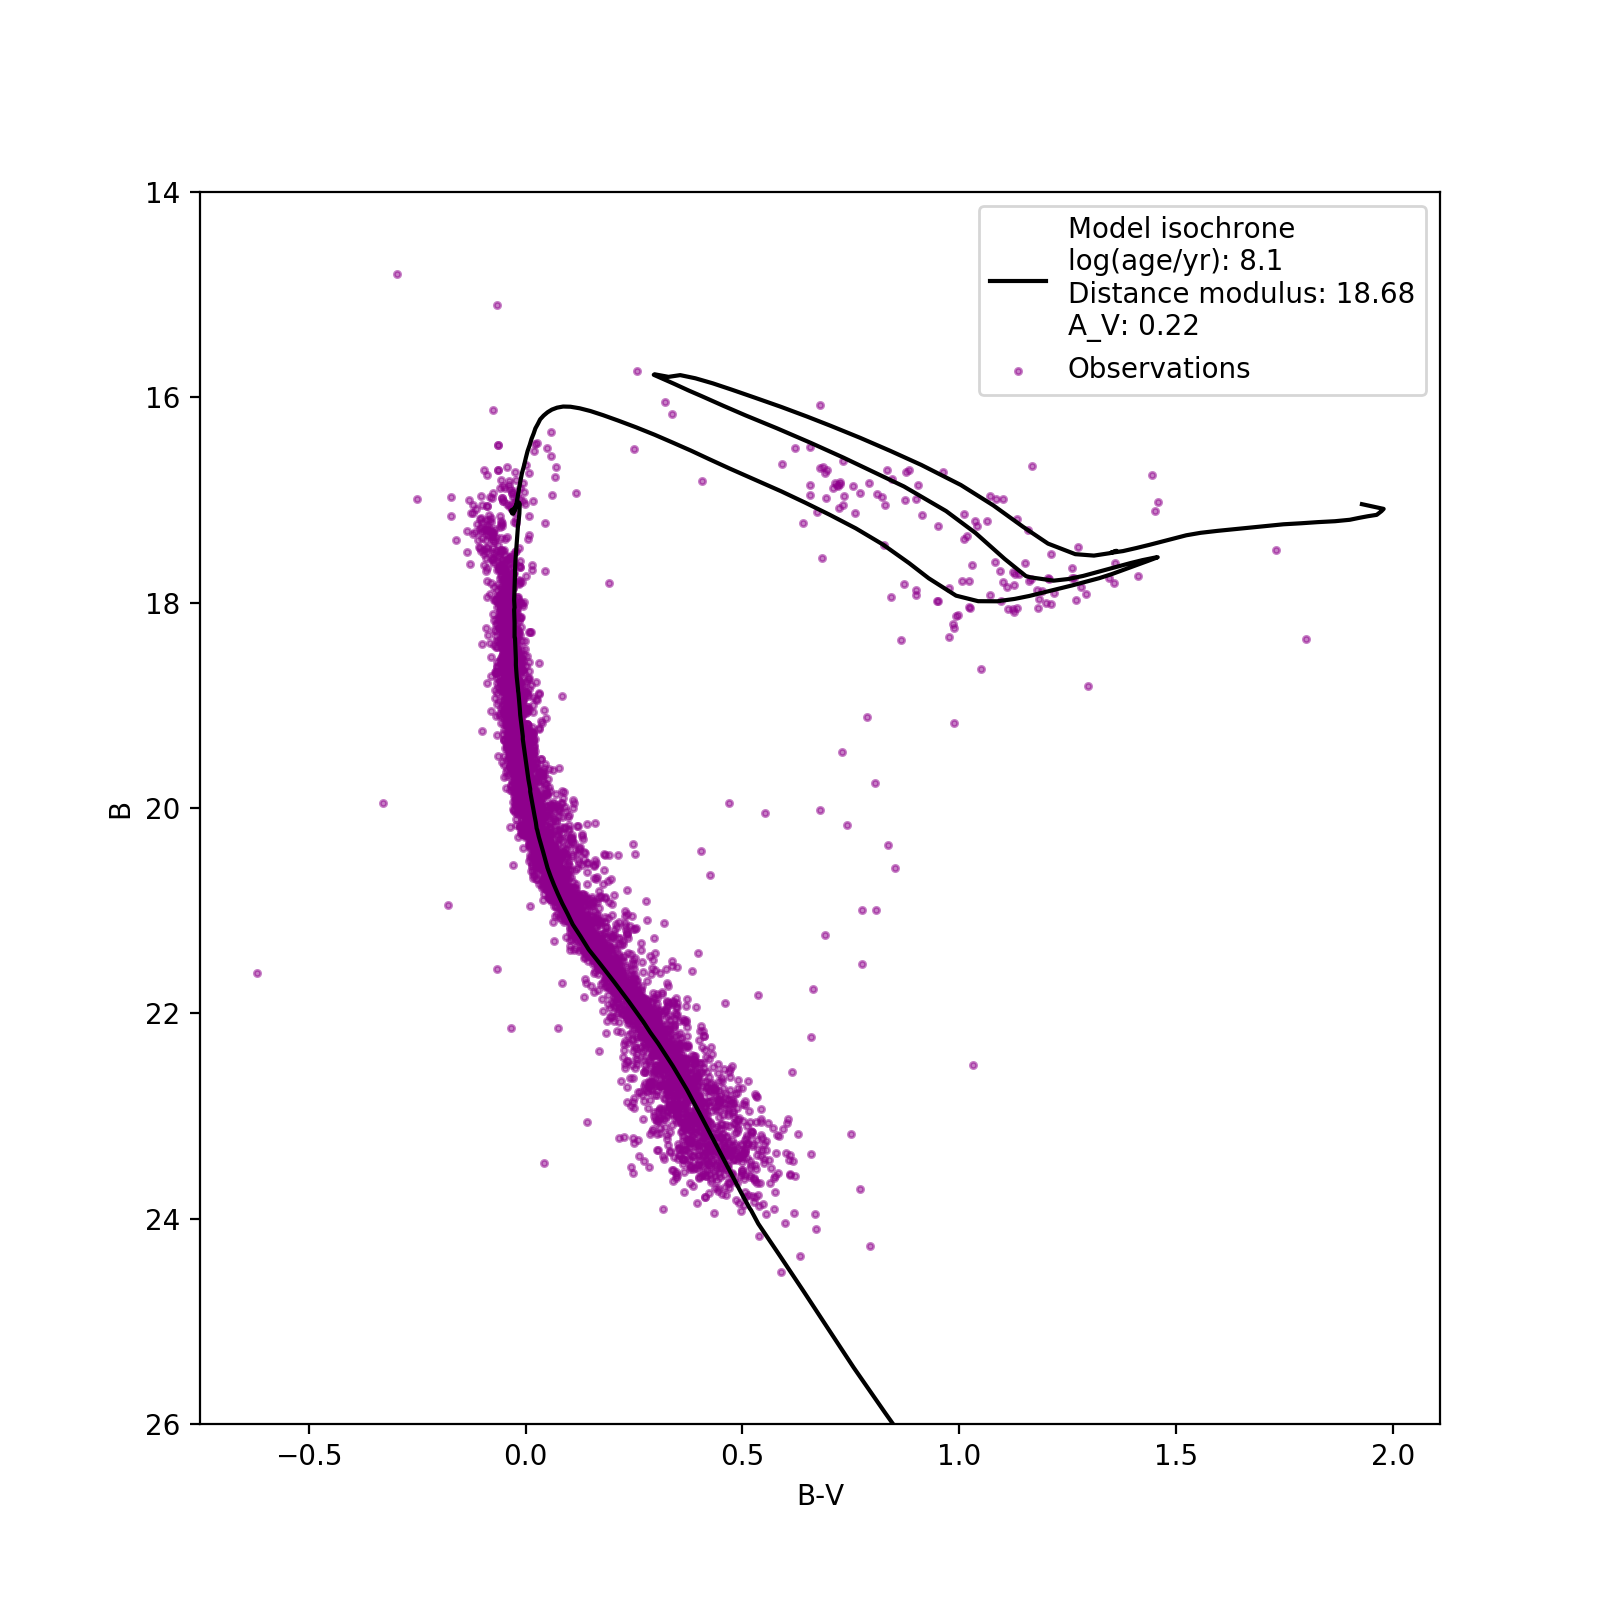

In [258]:
best_isochrone = isochrone_table[isochrone_table['log(age/yr)'] == age]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# observations    
ax.scatter(phot_table["f438w"]-phot_table["f555w"], phot_table["f438w"], 
           marker='o', c='#8e008c', alpha=0.5, s=5, label="Observations")

# isochrone 
ax.plot(best_isochrone["F438W"] - best_isochrone['F555W']  + (A_V*0.33),
        best_isochrone["F438W"] + dist_mod + (A_V*1.33), '-', color='black',
        label=f"Model isochrone\nlog(age/yr): {age:.3}\nDistance modulus: {dist_mod:.4}\nA_V: {A_V:.3}")

ax.set_ylim(26,14)

ax.legend()

ax.set_ylabel("B")
ax.set_xlabel("B-V")

plt.show()

### Eyeballing the fit based on the MSTO and post main sequence features

Leaving everything else the same and setting the age to 8.15 gives the following plot which I actually find of like better than the analytic fits (it has close but slightly larger error), if this is indeed a better fit, not sure how to fix my fit algorithm to agree with me. 

In [264]:
age = 8.15

observed_B_BV = list(zip(phot_table["f438w"], phot_table["f438w"]-phot_table["f555w"]))
single_age = isochrone_table[isochrone_table['log(age/yr)'] == age]
model_B_BV = list(zip(single_age["F438W"] + dist_mod + (A_V*1.33), 
                      single_age["F438W"] - single_age['F555W']  + (A_V*0.33)))
        
mean_sq_err = get_fit_err(model_B_BV, observed_B_BV)

print(f"Mean square error for log(age/year) = 8.15: {mean_sq_err:.2}")

Mean square error for log(age/year) = 8.15: 0.007


<IPython.core.display.Javascript object>


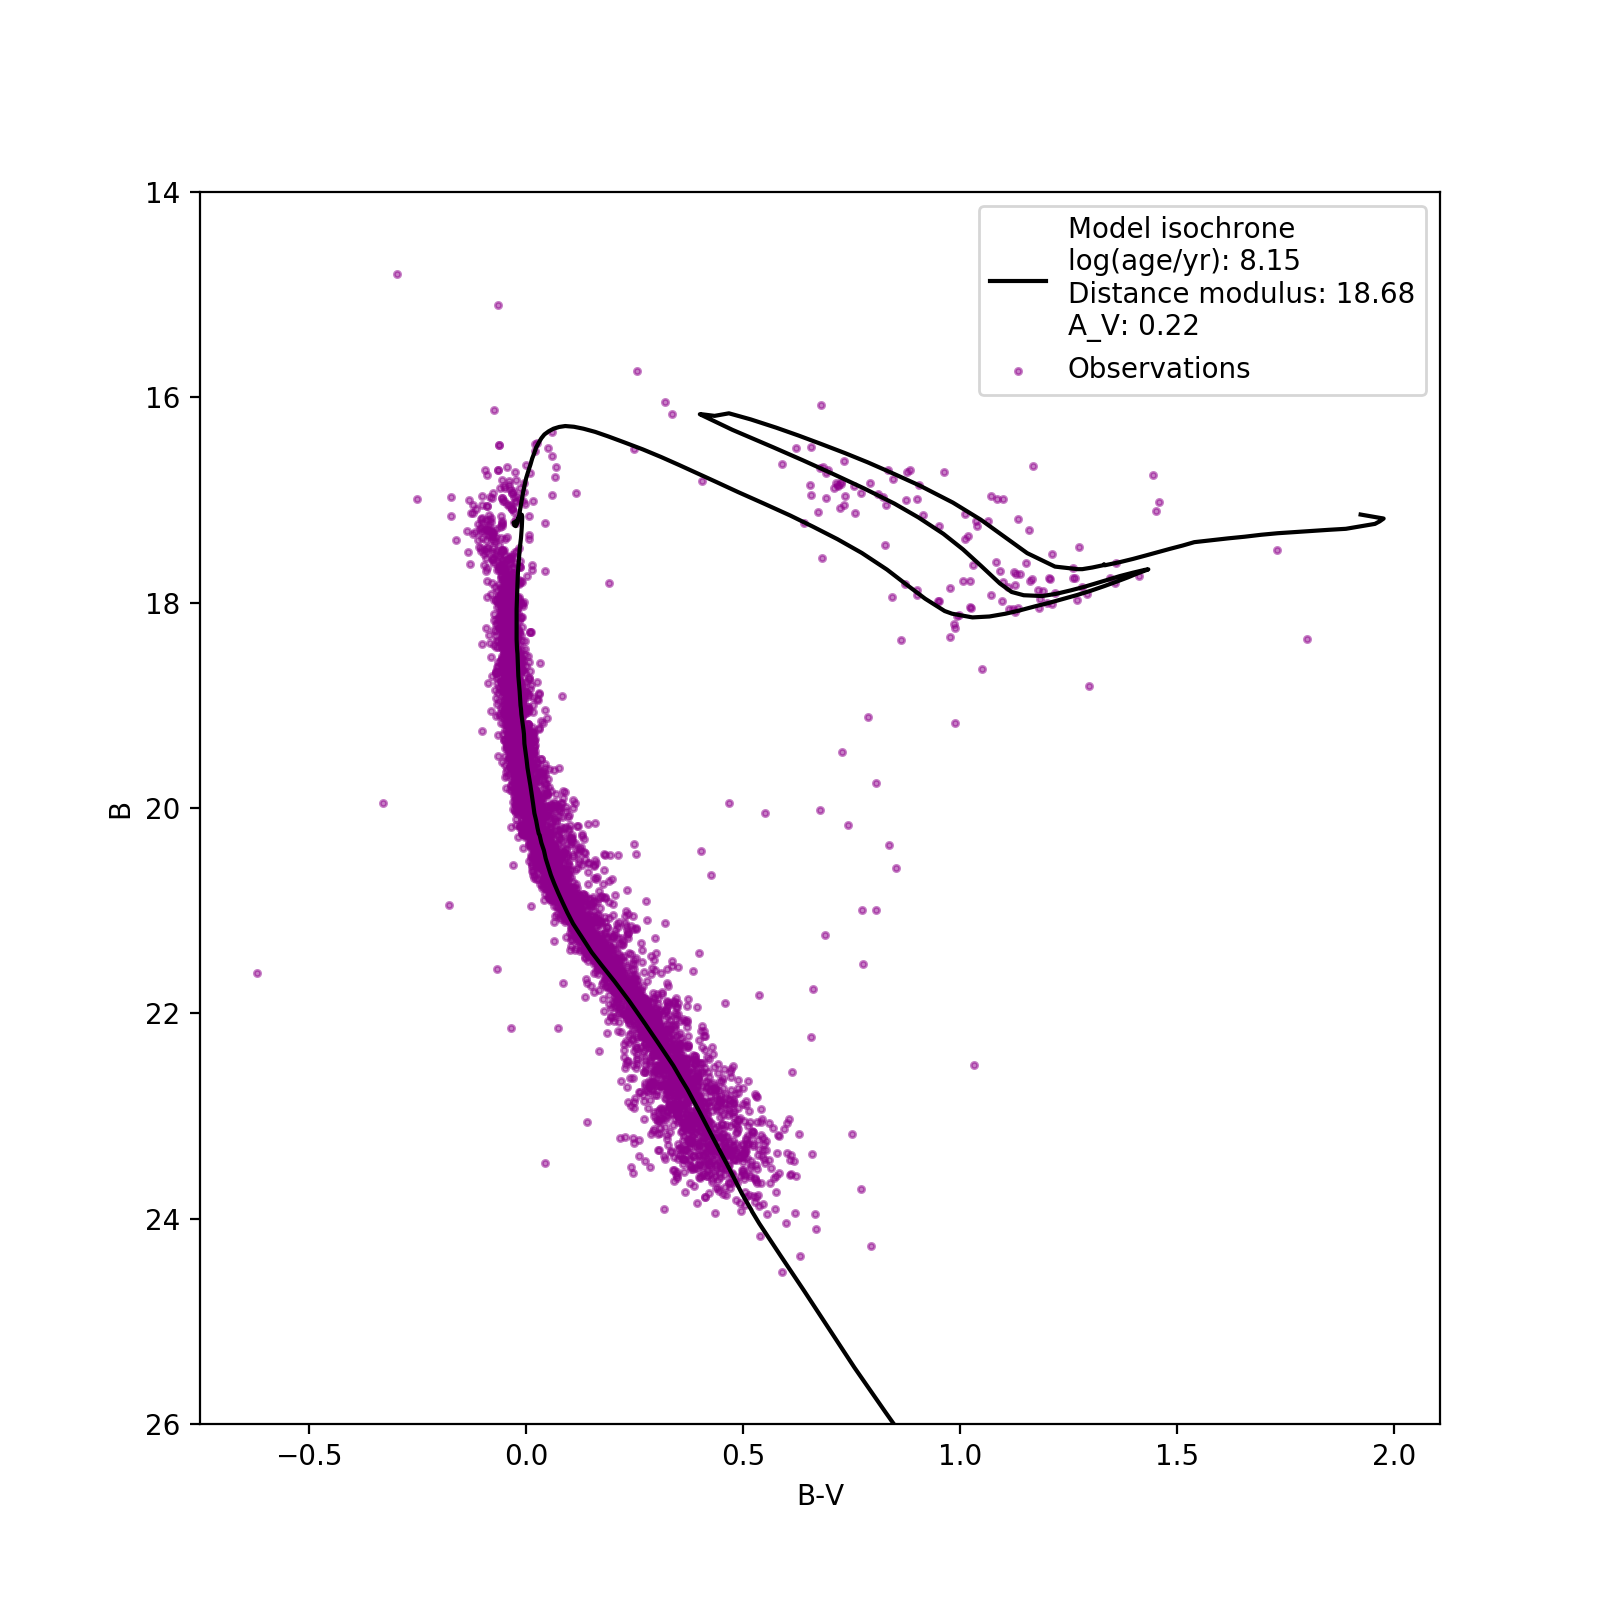

In [265]:
best_isochrone = isochrone_table[isochrone_table['log(age/yr)'] == age]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# observations    
ax.scatter(phot_table["f438w"]-phot_table["f555w"], phot_table["f438w"], 
           marker='o', c='#8e008c', alpha=0.5, s=5, label="Observations")

# isochrone 
ax.plot(best_isochrone["F438W"] - best_isochrone['F555W']  + (A_V*0.33),
        best_isochrone["F438W"] + dist_mod + (A_V*1.33), '-', color='black',
        label=f"Model isochrone\nlog(age/yr): {age:.3}\nDistance modulus: {dist_mod:.4}\nA_V: {A_V:.3}")

ax.set_ylim(26,14)

ax.legend()

ax.set_ylabel("B")
ax.set_xlabel("B-V")

plt.show()